# General Section:

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import drive
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Dataset path and parameters
dataset_path = "/content/drive/MyDrive/CLDD_Dataset/Original Dataset"
img_height, img_width = 224, 224
batch_size = 32
class_names = ['Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
               'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation']

Mounted at /content/drive


In [ ]:
# Ensure GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU is available:", physical_devices)
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU available, using CPU.")

GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Load dataset
train_data, val_data = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    label_mode='categorical'
)

print("Classes found:", os.listdir(dataset_path))
print(f"Class names: {train_data.class_names}")

Found 2137 files belonging to 7 classes.
Using 1710 files for training.
Using 427 files for validation.
Classes found: ['Bacterial Blight', 'Herbicide Growth Damage', 'Healthy Leaf', 'Curl Virus', 'Leaf Variegation', 'Leaf Hopper Jassids', 'Leaf Redding']
Class names: ['Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage', 'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation']


In [ ]:
# Function to count samples per class
def count_samples_per_class(dataset):
    class_counts = {name: 0 for name in class_names}
    for _, labels in dataset:
        labels = np.argmax(labels.numpy(), axis=1)
        for label in labels:
            class_counts[class_names[label]] += 1
    return class_counts

# Function to show images
def show_images(dataset, max_row=2, max_col=5):
    plt.figure(figsize=(20, 10))
    for images, labels in dataset.take(1):
        for i in range(min(max_row * max_col, len(images))):
            r, c = i // max_col, i % max_col
            ax = plt.subplot(max_row, max_col, i + 1)
            ax.imshow(images[i].numpy().astype('uint8'))
            ax.set_title(class_names[np.argmax(labels[i])])
            ax.axis('off')
    plt.show()

# Primary Augmentation:

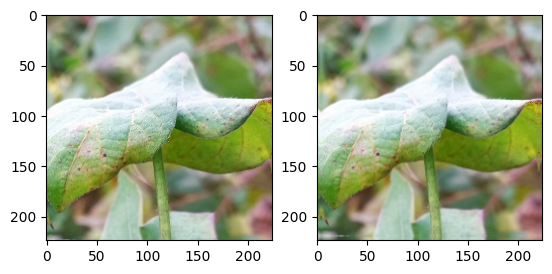

In [ ]:
# Augmentation pipeline
AUG = tf.keras.Sequential([
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

# Visualize original and augmented images
_, axs = plt.subplots(1, 2)
for images, labels in train_data.take(1):
    axs[0].imshow(images[0].numpy().astype('uint8'))
    img = AUG(images[0], training=True)
    axs[1].imshow(img.numpy().astype('uint8'))
plt.show()

In [ ]:
# Augmentation function
def augment_data(dataset):
    augmented_images = []
    augmented_labels = []
    for images, labels in dataset:
        for idx in range(len(images)):
            image = images[idx]
            label = labels[idx]
            aug_img = AUG(image, training=True)
            augmented_images.extend([image, aug_img])
            augmented_labels.extend([label, label])
    return augmented_images, augmented_labels


augmented_images, augmented_labels = augment_data(train_data)
training_aug_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
training_aug_data = training_aug_data.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

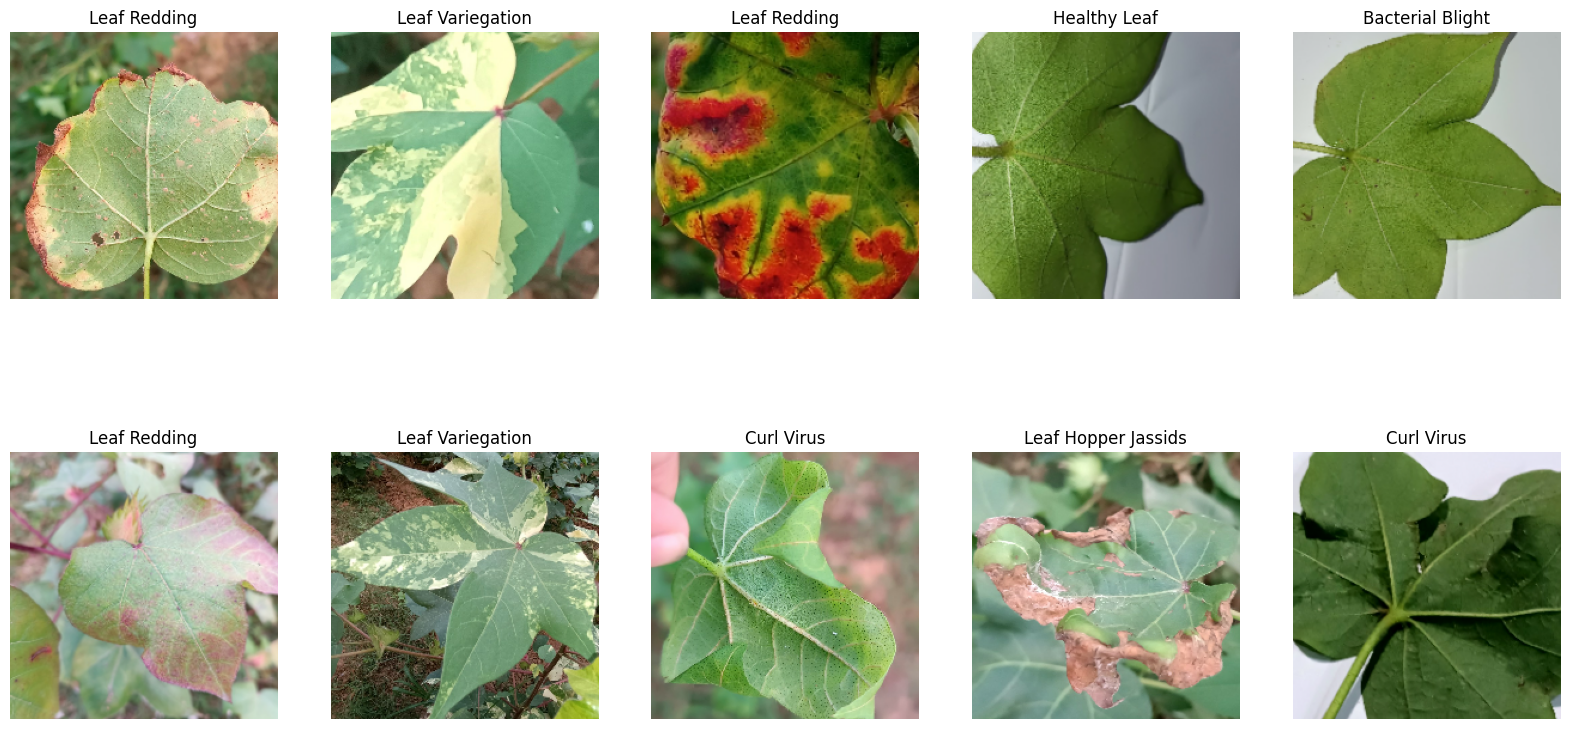

Original train data class counts: {'Bacterial Blight': 205, 'Curl Virus': 357, 'Healthy Leaf': 208, 'Herbicide Growth Damage': 219, 'Leaf Hopper Jassids': 176, 'Leaf Redding': 458, 'Leaf Variegation': 87}
Augmented train data class counts: {'Bacterial Blight': 410, 'Curl Virus': 714, 'Healthy Leaf': 416, 'Herbicide Growth Damage': 438, 'Leaf Hopper Jassids': 352, 'Leaf Redding': 916, 'Leaf Variegation': 174}


In [ ]:
show_images(training_aug_data)

print(f"Original train data class counts: {count_samples_per_class(train_data)}")
print(f"Augmented train data class counts: {count_samples_per_class(training_aug_data)}")

In [ ]:
# Preprocess input for Xception
def preprocess_input(image, label):
    image = tf.keras.applications.xception.preprocess_input(image)
    return image, label

training_aug_data = training_aug_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Compute class weights for imbalance
class_counts = {
    'Bacterial Blight': 205, 'Curl Virus': 357, 'Healthy Leaf': 208,
    'Herbicide Growth Damage': 219, 'Leaf Hopper Jassids': 176,
    'Leaf Redding': 458, 'Leaf Variegation': 87
}
labels = []
for name, count in class_counts.items():
    label_idx = class_names.index(name)
    labels.extend([label_idx] * count)
labels = np.array(labels)
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.1916376306620209), 1: np.float64(0.6842737094837935), 2: np.float64(1.1744505494505495), 3: np.float64(1.1154598825831703), 4: np.float64(1.3879870129870129), 5: np.float64(0.5333749220212103), 6: np.float64(2.8078817733990147)}


In [ ]:
# Load Xception model
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 21,914,159 (83.60 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.5682 - loss: 1.1442 - val_accuracy: 0.7705 - val_loss: 0.6456
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 0.8230 - loss: 0.4509 - val_accuracy: 0.8548 - val_loss: 0.3633
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - accuracy: 0.8743 - loss: 0.2991 - val_accuracy: 0.8478 - val_loss: 0.4066
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 17s 156ms/step - accuracy: 0.9079 - loss: 0.2336 - val_accuracy: 0.8759 - val_loss: 0.3315
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 149ms/step - accuracy: 0.9340 - loss: 0.1780 - val_accuracy: 0.8899 - val_loss: 0.2962
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - accuracy: 0.9369 - loss: 0.1581 - val_accuracy: 0.8993 - val_loss: 0.2946
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.9440 - loss: 0.1326 - val_accuracy: 0.8829 - val_loss: 0.2885
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 20s 151ms/step - accuracy: 0.9567 - loss: 0.1

In [ ]:
# Stage 2: Fine-tune last 40 layers (exclude BatchNormalization)
for layer in base_model.layers[-40:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print("Fine-tuning the last 40 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict
)

Fine-tuning the last 40 layers...
Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 52s 342ms/step - accuracy: 0.9257 - loss: 0.2020 - val_accuracy: 0.9157 - val_loss: 0.2666
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 225ms/step - accuracy: 0.9866 - loss: 0.0435 - val_accuracy: 0.9180 - val_loss: 0.3263
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 41s 226ms/step - accuracy: 0.9883 - loss: 0.0291 - val_accuracy: 0.9368 - val_loss: 0.2803
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - accuracy: 0.9928 - loss: 0.0170 - val_accuracy: 0.9251 - val_loss: 0.2781
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 43s 249ms/step - accuracy: 0.9926 - loss: 0.0155 - val_accuracy: 0.9087 - val_loss: 0.3625
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.9941 - loss: 0.0111 - val_accuracy: 0.9415 - val_loss: 0.2265
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 25s 229ms/step - accuracy: 0.9987 - loss: 0.0040 - val_accuracy: 0.9391 - val_loss: 0.2629
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 24s 226ms

In [ ]:
# Evaluate model
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(np.argmax(labels.numpy(), axis=1))
    y_val_pred.extend(np.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred)
print(conf_matrix)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.9328 - loss: 0.3012
Validation loss: 0.2212, Validation accuracy: 0.9555
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.90      0.98      0.94        45
             Curl Virus       0.97      0.96      0.97        74
           Healthy Leaf       0.92      0.96      0.94        49
Herbicide Growth Damage       1.00      1.00    

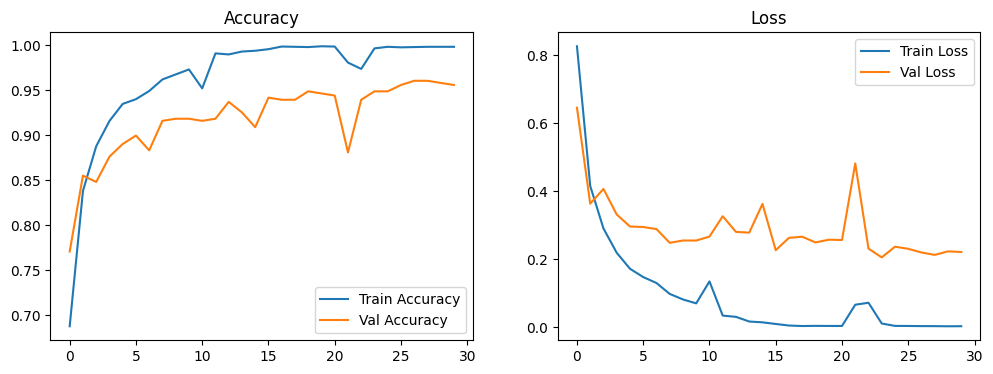

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

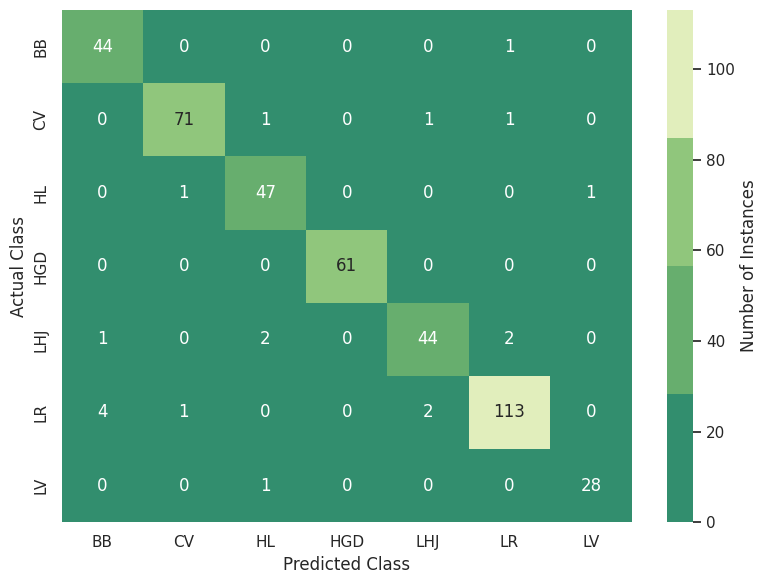

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [ 44,   0,   0,   0,   0,   1,   0],
 [  0, 71,   1,   0,   1,   1,   0],
 [  0,   1,  47,   0,   0,   0,   1],
 [  0,   0,   0,  61,   0,   0,   0],
 [  1,   0,   2,   0,  44,   2,   0],
 [  4,   1,   0,   0,   2, 113,   0],
 [  0,   0,   1,   0,   0,   0,  28]
])

# Define class names and their abbreviations
class_names = [
    'Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
    'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation'
]
class_abbr = ['BB', 'CV', 'HL', 'HGD', 'LHJ', 'LR', 'LV']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

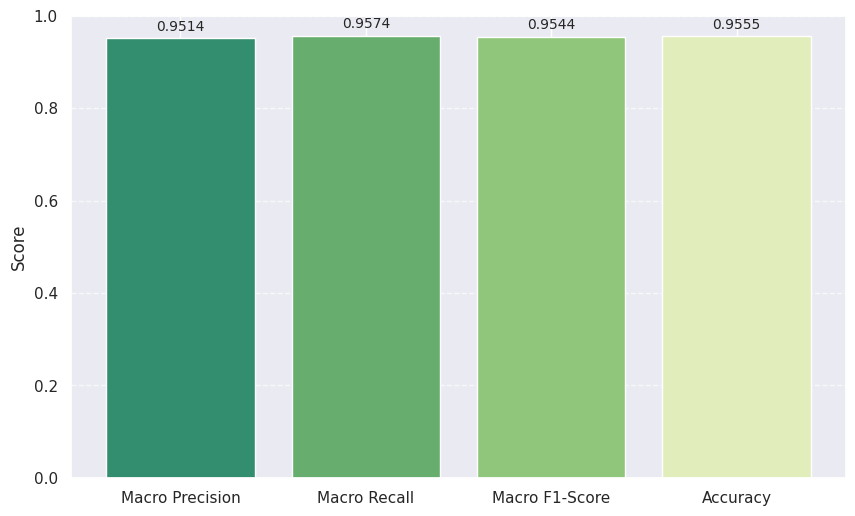

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 44,   0,   0,   0,   0,   1,   0],
 [  0, 71,   1,   0,   1,   1,   0],
 [  0,   1,  47,   0,   0,   0,   1],
 [  0,   0,   0,  61,   0,   0,   0],
 [  1,   0,   2,   0,  44,   2,   0],
 [  4,   1,   0,   0,   2, 113,   0],
 [  0,   0,   1,   0,   0,   0,  28]])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandZC_FT40DL] from Confusion Matrix', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.savefig('FT40DL_Xception_evaluation_metrics[RandZoomNContrast].png')

# Checkpoint 2_A (Double Augmentation):

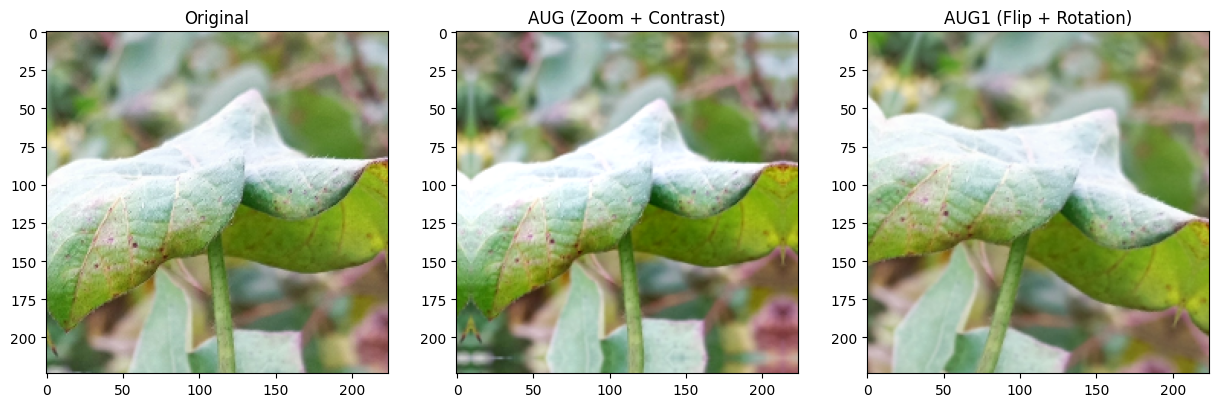

In [ ]:
# Augmentation pipelines
AUG = tf.keras.Sequential([
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.15),
])

AUG1 = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Visualize original and augmented images
def visualize_augmentation(dataset):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))
    for images, labels in dataset.take(1):
        img = images[0]
        axs[0].imshow(img.numpy().astype('uint8'))
        axs[0].set_title("Original")
        axs[1].imshow(AUG(img, training=True).numpy().astype('uint8'))
        axs[1].set_title("AUG (Zoom + Contrast)")
        axs[2].imshow(AUG1(img, training=True).numpy().astype('uint8'))
        axs[2].set_title("AUG1 (Flip + Rotation)")
        plt.show()

visualize_augmentation(train_data)

In [ ]:
# Augmentation function
def augment_data(dataset):
    augmented_images = []
    augmented_labels = []
    for images, labels in dataset:
        for idx in range(len(images)):
            image = images[idx]
            label = labels[idx]
            aug_img = AUG(image, training=True)
            aug_img1 = AUG1(image, training=True)
            augmented_images.extend([image, aug_img, aug_img1])
            augmented_labels.extend([label, label, label])
    return augmented_images, augmented_labels


augmented_images, augmented_labels = augment_data(train_data)
training_aug_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
training_aug_data = training_aug_data.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Preprocess input for Xception
def preprocess_input(image, label):
    image = tf.keras.applications.xception.preprocess_input(image)
    return image, label

training_aug_data = training_aug_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Compute class weights for imbalance
class_counts = {
    'Bacterial Blight': 205, 'Curl Virus': 357, 'Healthy Leaf': 208,
    'Herbicide Growth Damage': 219, 'Leaf Hopper Jassids': 176,
    'Leaf Redding': 458, 'Leaf Variegation': 87
}
labels = []
for name, count in class_counts.items():
    label_idx = class_names.index(name)
    labels.extend([label_idx] * count)
labels = np.array(labels)
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.1916376306620209), 1: np.float64(0.6842737094837935), 2: np.float64(1.1744505494505495), 3: np.float64(1.1154598825831703), 4: np.float64(1.3879870129870129), 5: np.float64(0.5333749220212103), 6: np.float64(2.8078817733990147)}


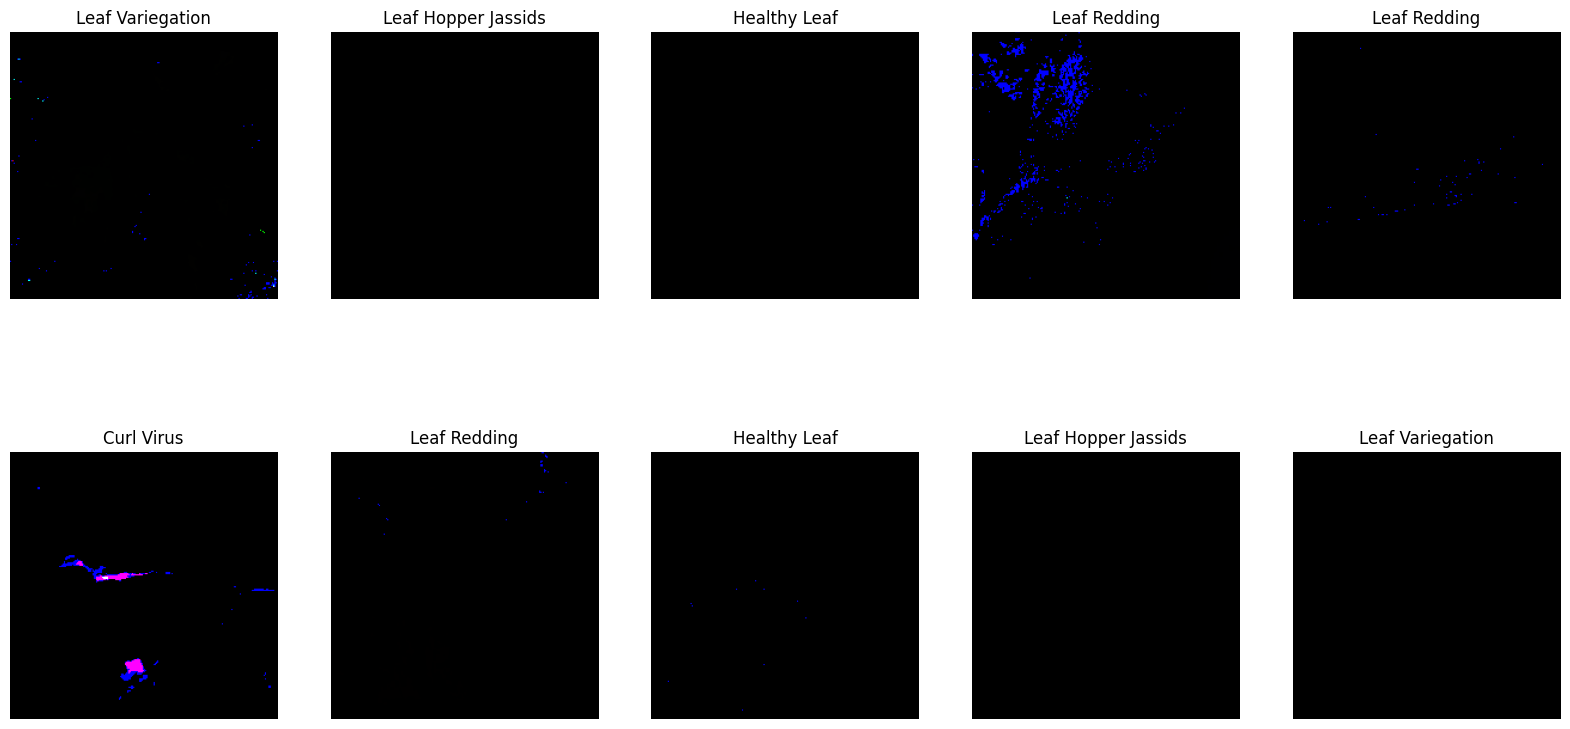

Original train data class counts: {'Bacterial Blight': 205, 'Curl Virus': 357, 'Healthy Leaf': 208, 'Herbicide Growth Damage': 219, 'Leaf Hopper Jassids': 176, 'Leaf Redding': 458, 'Leaf Variegation': 87}
Augmented train data class counts: {'Bacterial Blight': 615, 'Curl Virus': 1071, 'Healthy Leaf': 624, 'Herbicide Growth Damage': 657, 'Leaf Hopper Jassids': 528, 'Leaf Redding': 1374, 'Leaf Variegation': 261}


In [ ]:
show_images(training_aug_data)

# Verify class distribution
print(f"Original train data class counts: {count_samples_per_class(train_data)}")
print(f"Augmented train data class counts: {count_samples_per_class(training_aug_data)}")

In [ ]:
# Load Xception model
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 21,914,159 (83.60 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 139s 776ms/step - accuracy: 0.6120 - loss: 1.0312 - val_accuracy: 0.8056 - val_loss: 0.5047
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 30s 130ms/step - accuracy: 0.8320 - loss: 0.4255 - val_accuracy: 0.8782 - val_loss: 0.3508
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 44s 147ms/step - accuracy: 0.8726 - loss: 0.3245 - val_accuracy: 0.8829 - val_loss: 0.3496
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 132ms/step - accuracy: 0.8932 - loss: 0.2622 - val_accuracy: 0.8829 - val_loss: 0.3406
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 133ms/step - accuracy: 0.9162 - loss: 0.2033 - val_accuracy: 0.9063 - val_loss: 0.2791
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.9303 - loss: 0.1712 - val_accuracy: 0.8970 - val_loss: 0.2931
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.9357 - loss: 0.1535 - val_accuracy: 0.8946 - val_loss: 0.2675
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 22s 138ms/step - accuracy: 0.9459 - loss: 

In [ ]:
# Stage 2: Fine-tune last 50 layers (exclude BatchNormalization)
for layer in base_model.layers[-50:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print("Fine-tuning the last 50 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict
)

Fine-tuning the last 50 layers...
Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 270ms/step - accuracy: 0.9762 - loss: 0.0617 - val_accuracy: 0.9251 - val_loss: 0.2269
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step - accuracy: 0.9873 - loss: 0.0360 - val_accuracy: 0.9274 - val_loss: 0.2080
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 44s 234ms/step - accuracy: 0.9923 - loss: 0.0218 - val_accuracy: 0.9274 - val_loss: 0.1985
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 38s 217ms/step - accuracy: 0.9951 - loss: 0.0149 - val_accuracy: 0.9297 - val_loss: 0.2125
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 35s 219ms/step - accuracy: 0.9961 - loss: 0.0102 - val_accuracy: 0.9344 - val_loss: 0.2126
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - accuracy: 0.9969 - loss: 0.0096 - val_accuracy: 0.9321 - val_loss: 0.2017
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 40s 217ms/step - accuracy: 0.9967 - loss: 0.0081 - val_accuracy: 0.9297 - val_loss: 0.2232
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms

In [ ]:
# Evaluate model
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(np.argmax(labels.numpy(), axis=1))
    y_val_pred.extend(np.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_val_true, y_val_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.9282 - loss: 0.3117
Validation loss: 0.2231, Validation accuracy: 0.9438
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.84      0.93      0.88        45
             Curl Virus       0.94      0.97      0.95        74
           Healthy Leaf       0.94      0.92      0.93        49
Herbicide Growth Damage       1.00      1.00    

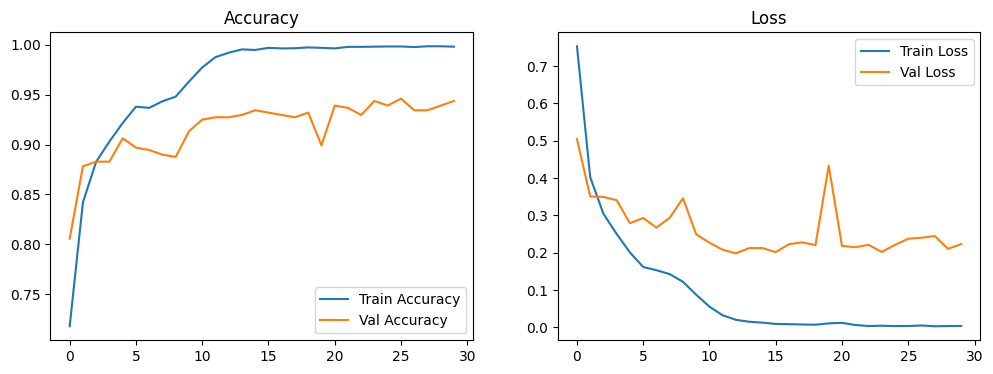

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.savefig('Xception_Accuracy_Loss_Graph[RandFlipNRotateRandZoomNContrast].png')

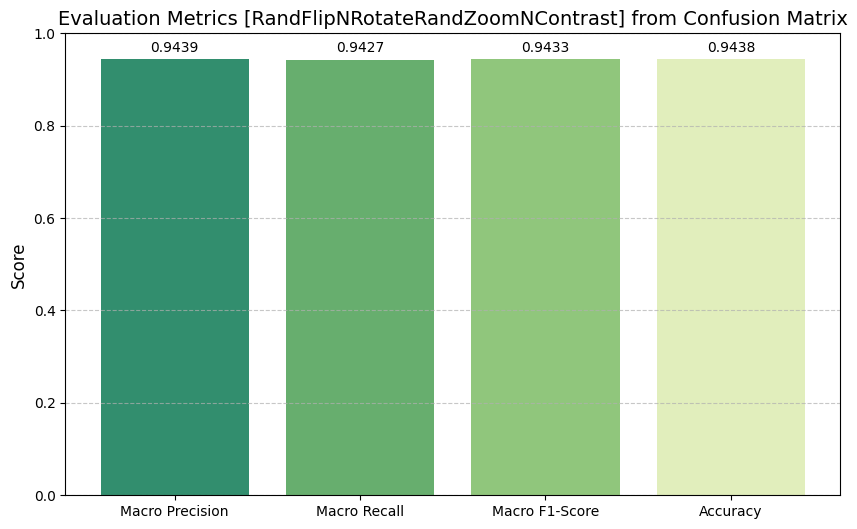

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 42,   0,   1,   0,   1,   1,   0],
 [  0,  72,   0,   0,   1,   1,   0],
 [  0,   3,  45,   0,   0,   1,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  1,   0,   1,   0,  45,   2,   0],
 [  6,   2,   0,   0,   1, 111,   0],
 [  1,   0,   1,   0,   0,   0,  27]])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
plt.title('Evaluation Metrics [RandFlipNRotateRandZoomNContrast] from Confusion Matrix', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.savefig('Xception_evaluation_metrics[RandFlipNRotateRandZoomNContrast].png')

# Checkpoint 2_B (Fine Tuning 40 Layers, Dropout and LR Tweaking):

In [ ]:
# Load Xception model
base_model = tf.keras.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_2[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 21,914,159 (83.60 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 129s 709ms/step - accuracy: 0.6298 - loss: 0.9654 - val_accuracy: 0.8197 - val_loss: 0.4888
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.8585 - loss: 0.3758 - val_accuracy: 0.8384 - val_loss: 0.4846
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.8996 - loss: 0.2619 - val_accuracy: 0.8314 - val_loss: 0.4713
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.9109 - loss: 0.2312 - val_accuracy: 0.8946 - val_loss: 0.3232
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.9385 - loss: 0.1531 - val_accuracy: 0.9016 - val_loss: 0.3069
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.9448 - loss: 0.1381 - val_accuracy: 0.9133 - val_loss: 0.2724
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 24s 148ms/step - accuracy: 0.9560 - loss: 0.1115 - val_accuracy: 0.9157 - val_loss: 0.2778
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 146ms/step - accuracy: 0.9636 - loss: 

In [ ]:
# Stage 2: Fine-tune last 40 layers (exclude BatchNormalization)
for layer in base_model.layers[-40:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print("Fine-tuning the last 40 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict
)

Fine-tuning the last 40 layers...
Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 285ms/step - accuracy: 0.9390 - loss: 0.1719 - val_accuracy: 0.9344 - val_loss: 0.2230
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 65s 223ms/step - accuracy: 0.9884 - loss: 0.0332 - val_accuracy: 0.9415 - val_loss: 0.2063
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 35s 220ms/step - accuracy: 0.9855 - loss: 0.0467 - val_accuracy: 0.9461 - val_loss: 0.2513
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 43s 234ms/step - accuracy: 0.9931 - loss: 0.0154 - val_accuracy: 0.9532 - val_loss: 0.2404
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 36s 225ms/step - accuracy: 0.9958 - loss: 0.0111 - val_accuracy: 0.9438 - val_loss: 0.2467
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - accuracy: 0.9857 - loss: 0.0439 - val_accuracy: 0.9415 - val_loss: 0.2467
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 40s 218ms/step - accuracy: 0.9964 - loss: 0.0076 - val_accuracy: 0.9508 - val_loss: 0.2391
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms

In [ ]:
# Evaluate model
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(np.argmax(labels.numpy(), axis=1))
    y_val_pred.extend(np.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred)
print(conf_matrix)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 0.9633 - loss: 0.2744
Validation loss: 0.1644, Validation accuracy: 0.9719
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.88      1.00      0.94        45
             Curl Virus       0.99      1.00      0.99        74
           Healthy Leaf       0.98      0.96      0.97        49
Herbicide Growth Damage       1.00      0.98    

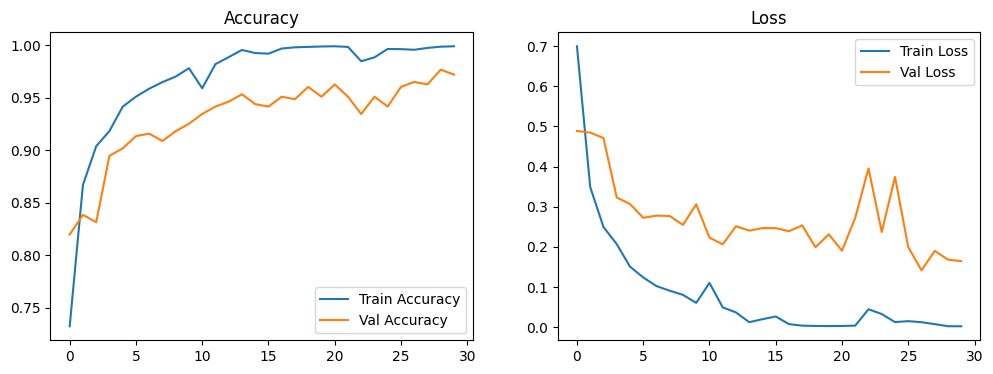

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

plt.savefig('FT30_Xception_Accuracy_Loss_Graph[RandFlipNRotateRandZoomNContrast].png')

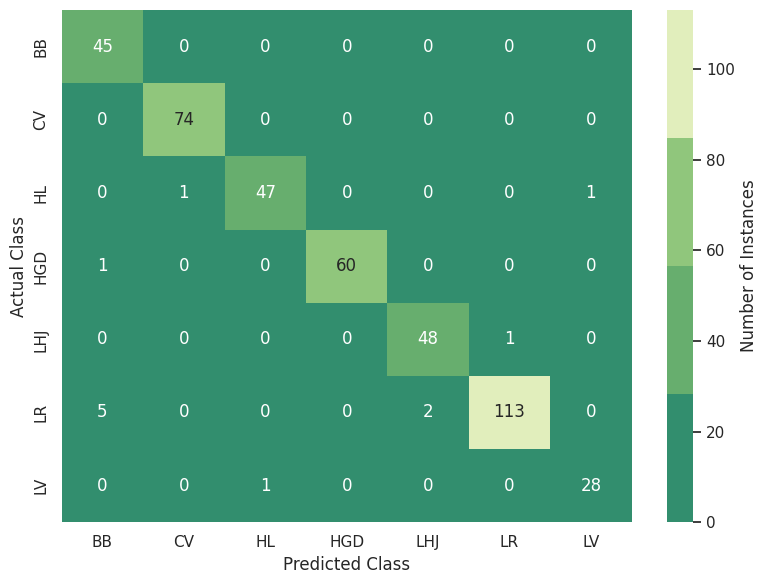

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  74,   0,   0,   0,   0,   0],
 [  0,   1,  47,   0,   0,   0,   1],
 [  1,   0,   0,  60,   0,   0,   0],
 [  0,   0,   0,   0,  48,   1,   0],
 [  5,   0,   0,   0,   2, 113,   0],
 [  0,   0,   1,   0,   0,   0,  28]
])

# Define class names and their abbreviations
class_names = [
    'Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
    'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation'
]
class_abbr = ['BB', 'CV', 'HL', 'HGD', 'LHJ', 'LR', 'LV']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

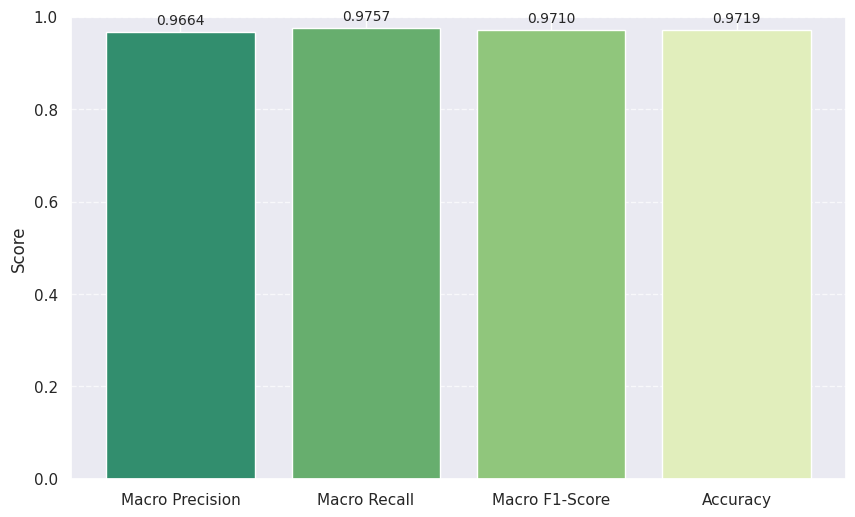

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  74,   0,   0,   0,   0,   0],
 [  0,   1,  47,   0,   0,   0,   1],
 [  1,   0,   0,  60,   0,   0,   0],
 [  0,   0,   0,   0,  48,   1,   0],
 [  5,   0,   0,   0,   2, 113,   0],
 [  0,   0,   1,   0,   0,   0,  28]])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandFR_ZC_FT40DL] from Confusion Matrix', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.savefig('FT40DL_Xception_evaluation_metrics[RandFlipNRotateRandZoomNContrast].png')